# Understanding requires_grad, retain_grad, Leaf, and Non-leaf Tensors

## Setup


In [1]:
import torch
import torch.nn.functional as F

Next, we instantiate a simple network to focus on the gradients. This will be an affine layer, followed by a ReLU activation, and ending with a MSE loss between prediction and label tensors.

Note that the requires_grad=True is necessary for the parameters (W and b) so that PyTorch tracks operations involving those tensors. We’ll discuss more about this in a future section.

In [2]:
# tensor setup
x = torch.ones(1, 3)                      # input with shape: (1, 3)
W = torch.ones(3, 2, requires_grad=True)  # weights with shape: (3, 2)
b = torch.ones(1, 2, requires_grad=True)  # bias with shape: (1, 2)
y = torch.ones(1, 2)                      # output with shape: (1, 2)

# forward pass
z = (x @ W) + b                           # pre-activation with shape: (1, 2)
y_pred = F.relu(z)                        # activation with shape: (1, 2)
loss = F.mse_loss(y_pred, y)              # scalar loss

## Leaf vs. non-leaf tensors

After running the forward pass, PyTorch autograd has built up a dynamic computational graph which is shown below. This is a Directed Acyclic Graph (DAG) which keeps a record of input tensors (leaf nodes), all subsequent operations on those tensors, and the intermediate/output tensors (non-leaf nodes). The graph is used to compute gradients for each tensor starting from the graph roots (outputs) to the leaves (inputs) using the chain rule from calculus:

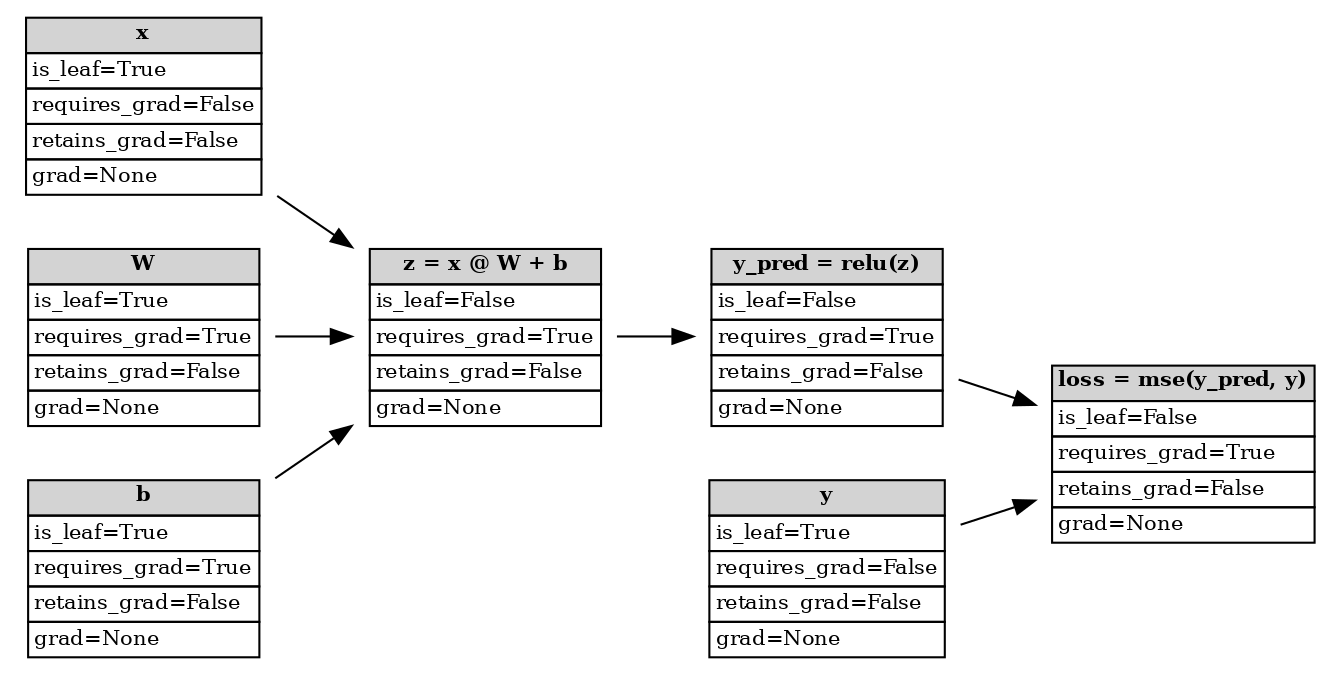

PyTorch considers a node to be a leaf if it is not the result of a tensor operation with at least one input having requires_grad=True (e.g. x, W, b, and y), and everything else to be non-leaf (e.g. z, y_pred, and loss). You can verify this programmatically by probing the is_leaf attribute of the tensors:

In [3]:
# prints True because new tensors are leafs by convention
print(f"{x.is_leaf=}")

# prints False because tensor is the result of an operation with at
# least one input having requires_grad=True
print(f"{z.is_leaf=}")

x.is_leaf=True
z.is_leaf=False


The distinction between leaf and non-leaf determines whether the tensor’s gradient will be stored in the grad property after the backward pass, and thus be usable for gradient descent. We’ll cover this some more in the following section.

Let’s now investigate how PyTorch calculates and stores gradients for the tensors in its computational graph.

## require_grad

To build the computational graph which can be used for gradient calculation, we need to pass in the requires_grad=True parameter to a tensor constructor. By default, the value is False, and thus PyTorch does not track gradients on any created tensors. To verify this, try not setting requires_grad, re-run the forward pass, and then run backpropagation. You will see:

In [4]:
# tensor setup
x = torch.ones(1, 3)                      # input with shape: (1, 3)
W = torch.ones(3, 2, requires_grad=False)  # weights with shape: (3, 2)
b = torch.ones(1, 2, requires_grad=False)  # bias with shape: (1, 2)
y = torch.ones(1, 2)                      # output with shape: (1, 2)

# forward pass
z = (x @ W) + b                           # pre-activation with shape: (1, 2)
y_pred = F.relu(z)                        # activation with shape: (1, 2)
loss = F.mse_loss(y_pred, y)              # scalar loss

In [5]:
>>> loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

This error means that autograd can’t backpropagate to any leaf tensors because loss is not tracking gradients. If you need to change the property, you can call requires_grad_() on the tensor (notice the _ suffix).

We can sanity check which nodes require gradient calculation, just like we did above with the is_leaf attribute:

In [7]:
# tensor setup
x = torch.ones(1, 3)                      # input with shape: (1, 3)
W = torch.ones(3, 2, requires_grad=True)  # weights with shape: (3, 2)
b = torch.ones(1, 2, requires_grad=True)  # bias with shape: (1, 2)
y = torch.ones(1, 2)                      # output with shape: (1, 2)

# forward pass
z = (x @ W) + b                           # pre-activation with shape: (1, 2)
y_pred = F.relu(z)                        # activation with shape: (1, 2)
loss = F.mse_loss(y_pred, y)              # scalar loss

In [8]:
print(f"{x.requires_grad=}") # prints False because requires_grad=False by default
print(f"{W.requires_grad=}") # prints True because we set requires_grad=True in constructor
print(f"{z.requires_grad=}") # prints True because tensor is a non-leaf node

x.requires_grad=False
W.requires_grad=True
z.requires_grad=True


It’s useful to remember that a non-leaf tensor has requires_grad=True by definition, since backpropagation would fail otherwise. If the tensor is a leaf, then it will only have requires_grad=True if it was specifically set by the user. Another way to phrase this is that if at least one of the inputs to a tensor requires the gradient, then it will require the gradient as well.

There are two exceptions to this rule:

Any nn.Module that has nn.Parameter will have requires_grad=True for its parameters (see here)

Locally disabling gradient computation with context managers (see here)

In summary, requires_grad tells autograd which tensors need to have their gradients calculated for backpropagation to work. This is different from which tensors have their grad field populated, which is the topic of the next section.

## retain_grad

To actually perform optimization (e.g. SGD, Adam, etc.), we need to run the backward pass so that we can extract the gradients.



In [9]:
loss.backward()

Calling backward() populates the grad field of all leaf tensors which had requires_grad=True. The grad is the gradient of the loss with respect to the tensor we are probing. Before running backward(), this attribute is set to None.

In [10]:
print(f"{W.grad=}")
print(f"{b.grad=}")

W.grad=tensor([[3., 3.],
        [3., 3.],
        [3., 3.]])
b.grad=tensor([[3., 3.]])


You might be wondering about the other tensors in our network. Let’s check the remaining leaf nodes:

In [11]:
# prints all None because requires_grad=False
print(f"{x.grad=}")
print(f"{y.grad=}")

x.grad=None
y.grad=None


The gradients for these tensors haven’t been populated because we did not explicitly tell PyTorch to calculate their gradient (requires_grad=False).

Let’s now look at an intermediate non-leaf node:

In [12]:
print(f"{z.grad=}")

z.grad=None


/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_25841/3749615215.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(f"{z.grad=}")


PyTorch returns None for the gradient and also warns us that a non-leaf node’s grad attribute is being accessed. Although autograd has to calculate intermediate gradients for backpropagation to work, it assumes you don’t need to access the values afterwards. To change this behavior, we can use the retain_grad() function on a tensor. This tells the autograd engine to populate that tensor’s grad after calling backward().



In [13]:
# we have to re-run the forward pass
z = (x @ W) + b
y_pred = F.relu(z)
loss = F.mse_loss(y_pred, y)

# tell PyTorch to store the gradients after backward()
z.retain_grad()
y_pred.retain_grad()
loss.retain_grad()

# have to zero out gradients otherwise they would accumulate
W.grad = None
b.grad = None

# backpropagation
loss.backward()

# print gradients for all tensors that have requires_grad=True
print(f"{W.grad=}")
print(f"{b.grad=}")
print(f"{z.grad=}")
print(f"{y_pred.grad=}")
print(f"{loss.grad=}")

W.grad=tensor([[3., 3.],
        [3., 3.],
        [3., 3.]])
b.grad=tensor([[3., 3.]])
z.grad=tensor([[3., 3.]])
y_pred.grad=tensor([[3., 3.]])
loss.grad=tensor(1.)



We get the same result for W.grad as before. Also note that because the loss is scalar, the gradient of the loss with respect to itself is simply 1.0.

If we look at the state of the computational graph now, we see that the retains_grad attribute has changed for the intermediate tensors. By convention, this attribute will print False for any leaf node, even if it requires its gradient.

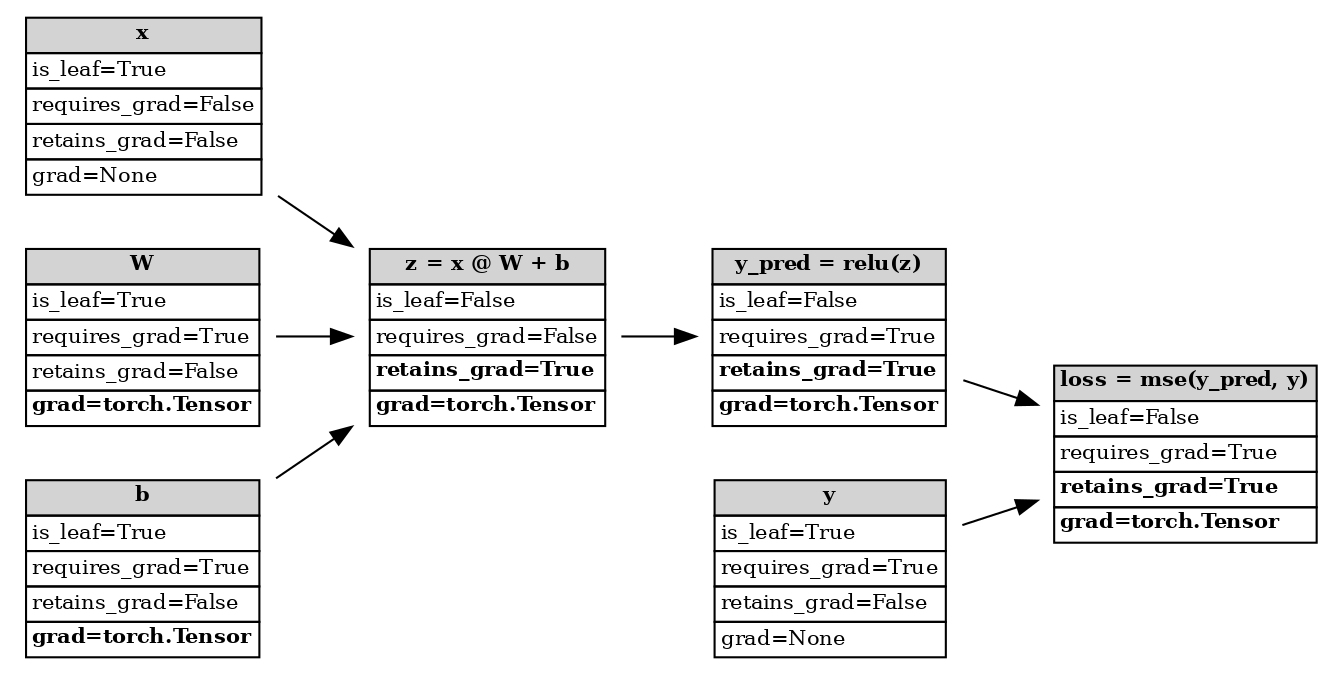

If you call retain_grad() on a non-leaf node, it results in a no-op. If we call retain_grad() on a node that has requires_grad=False, PyTorch actually throws an error, since it can’t store the gradient if it is never calculated.